In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
# Load dataset
df_combine = pd.read_csv('transaction_dataset.csv')
print('raw shape:', df_combine.shape)
display(df_combine.head())
f_txn = len(df_combine[df_combine['FLAG'] == 1])
print('current number of frauds:', f_txn, ' which is ', (f_txn/len(df_combine))*100, ' % of the original dataset')

raw shape: (9841, 51)


,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


current number of frauds: 2179  which is  22.14205873386851  % of the original dataset


In [3]:
# Basic cleaning: drop exact-NA rows and reset index
df_combine = df_combine.dropna().reset_index(drop=True)
print('after dropna shape:', df_combine.shape)

after dropna shape: (7121, 51)


In [4]:
# Check unique counts and dtypes
display(df_combine.nunique())
display(df_combine.dtypes.value_counts())

Unnamed: 0                                              7121
Index                                                   4191
Address                                                 7104
FLAG                                                       2
Avg min between sent tnx                                4054
Avg min between received tnx                            4058
Time Diff between first and last (Mins)                 5629
Sent tnx                                                 493
Received Tnx                                             468
Number of Created Contracts                               17
Unique Received From Addresses                           196
Unique Sent To Addresses                                 222
min value received                                      3829
max value received                                      4540
avg val received                                        4586
min val sent                                            3851
max val sent            

float64    39
int64       9
object      3
Name: count, dtype: int64

In [5]:
# Drop obvious low-variance / useless columns if present
constant_columns = ['Unnamed: 0', 'Index', ' ERC20 uniq sent addr.1', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']
cols_to_drop = [c for c in constant_columns if c in df_combine.columns]
if cols_to_drop:
    df_combine.drop(cols_to_drop, axis=1, inplace=True)
    print('dropped columns:', cols_to_drop)
print('shape after dropping constants:', df_combine.shape)

dropped columns: ['Unnamed: 0', 'Index', ' ERC20 uniq sent addr.1', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']
shape after dropping constants: (7121, 43)


### Notes on Data Leakage Prevention

**IMPORTANT: This notebook has been updated to prevent data leakage:**

1. **Train-Test Split First**: Data is split BEFORE any preprocessing or model training
2. **Pipeline-Based Preprocessing**: All preprocessing (SMOTE) is inside the pipeline, ensuring it only fits on training folds during cross-validation
3. **No StandardScaler**: Removed unnecessary StandardScaler - Random Forest is tree-based and doesn't benefit from feature scaling
4. **Test Set Isolation**: Test set remains completely untouched until final evaluation
5. **Cross-Validation Safety**: GridSearchCV/RandomizedSearchCV use cross-validation, so preprocessing only fits on training folds, not validation folds

**Key Principle**: The test set should never influence any aspect of model training, including preprocessing parameter estimation.

If `imbalanced-learn` is not installed, run `pip install imbalanced-learn` in your environment.

In [6]:
# Prepare numeric-only DataFrame for Random Forest
print('Selecting numeric columns...')
df_combine_forest = df_combine.select_dtypes(include='number').copy()
print('numeric df shape:', df_combine_forest.shape)
# Ensure target exists
if 'FLAG' not in df_combine_forest.columns:
    raise KeyError('FLAG column not found in numeric dataframe')
print('Dropped non-numeric columns (if any)')

Selecting numeric columns...
numeric df shape: (7121, 40)
Dropped non-numeric columns (if any)


In [7]:
# Features / target split
X = df_combine_forest.drop('FLAG', axis=1)
y = df_combine_forest['FLAG']
print('X shape, y shape:', X.shape, y.shape)
print('Class distribution (counts):')
print(y.value_counts())

X shape, y shape: (7121, 39) (7121,)
Class distribution (counts):
FLAG
0    5771
1    1350
Name: count, dtype: int64


In [8]:
from sklearn.model_selection import train_test_split

# CRITICAL: Split data FIRST before any preprocessing to prevent data leakage
# This ensures test set is completely unseen during training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=0.7, 
    random_state=42, 
    stratify=y
)

print('Train / test shapes:', X_train.shape, X_test.shape)
print('Train class distribution:')
print(y_train.value_counts())
print('\nIMPORTANT: Test set will remain untouched until final evaluation!')

Train / test shapes: (4984, 39) (2137, 39)
Train class distribution:
FLAG
0    4039
1     945
Name: count, dtype: int64

IMPORTANT: Test set will remain untouched until final evaluation!


In [9]:
# Create pipeline: SMOTE -> RandomForest (NO SCALER - RF is tree-based and doesn't need scaling)
# NOTE: All preprocessing must be inside pipeline to prevent data leakage
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# imbalanced-learn sampler will be used inside pipeline via 'imblearn.pipeline' if available
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    sampler_available = True
except Exception as e:
    print('imblearn not available. Install with: pip install imbalanced-learn')
    sampler_available = False

# Define pipeline depending on availability
# IMPORTANT: No StandardScaler - Random Forest is tree-based and doesn't benefit from scaling
# All preprocessing steps are inside the pipeline to ensure they only fit on training folds during CV
if sampler_available:
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)), 
        ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
    ])
else:
    # If SMOTE not available, use basic pipeline without balancing
    pipeline = Pipeline([
        ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
    ])
print('Pipeline created:', pipeline)
print('NOTE: All preprocessing is inside pipeline to prevent data leakage')

imblearn not available. Install with: pip install imbalanced-learn
Pipeline created: Pipeline(steps=[('rf', RandomForestClassifier(n_jobs=-1, random_state=42))])
NOTE: All preprocessing is inside pipeline to prevent data leakage


In [10]:
# GridSearch for sensible hyperparameters (kept smaller to run faster)
# NOTE: GridSearchCV uses cross-validation, so preprocessing in pipeline only fits on training folds
from sklearn.model_selection import GridSearchCV

params = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_leaf': [1, 5]
}

# GridSearchCV will internally split X_train into folds
# Pipeline ensures scaler/SMOTE only fit on training folds, not validation folds
grid = GridSearchCV(
    pipeline, 
    param_grid=params, 
    cv=4, 
    scoring='f1', 
    n_jobs=-1, 
    verbose=1,
    return_train_score=False  # Don't compute train scores to save time
)
grid.fit(X_train, y_train)  # Only uses training data - test set untouched!
print('Best CV f1:', grid.best_score_)
print('Best params:', grid.best_params_)
best_pipeline = grid.best_estimator_

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best CV f1: 0.9682125742002204
Best params: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}


In [11]:
# Advanced hyperparameter tuning using RandomizedSearchCV (faster over large spaces)
# NOTE: RandomizedSearchCV uses cross-validation - all preprocessing stays within pipeline
from sklearn.model_selection import RandomizedSearchCV

# Parameter distributions for the RF inside the pipeline (prefix with 'rf__')
param_dist = {
    'rf__n_estimators': [100, 200, 300, 400, 500],
    'rf__max_depth': [None, 5, 10, 15, 20, 30],
    'rf__min_samples_leaf': [1, 2, 4, 6, 8, 10],
    'rf__max_features': ['sqrt', 'log2', 0.2, 0.5],
    'rf__bootstrap': [True, False]
}

# Run randomized search (n_iter kept moderate to limit runtime)
# IMPORTANT: Only X_train, y_train used - test set remains completely untouched
random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=40, 
    cv=4, 
    scoring='f1', 
    n_jobs=-1, 
    verbose=2, 
    random_state=42,
    return_train_score=False  # Don't compute train scores to save time
)
random_search.fit(X_train, y_train)  # Only training data - no data leakage!
print('RandomizedSearch best CV f1:', random_search.best_score_)
print('RandomizedSearch best params:')
print(random_search.best_params_)

# Use the best estimator from randomized search as the final pipeline
# This estimator has been refit on the FULL training set by RandomizedSearchCV
best_pipeline = random_search.best_estimator_
print('\nBest pipeline refit on full training set and ready for test evaluation')

Fitting 4 folds for each of 40 candidates, totalling 160 fits
RandomizedSearch best CV f1: 0.9744282720079034
RandomizedSearch best params:
{'rf__n_estimators': 500, 'rf__min_samples_leaf': 2, 'rf__max_features': 0.5, 'rf__max_depth': None, 'rf__bootstrap': False}

Best pipeline refit on full training set and ready for test evaluation


FINAL EVALUATION ON TEST SET (unseen during training)

Classification report:
              precision    recall  f1-score   support

  Legitimate     0.9875    1.0000    0.9937      1732
       Fraud     1.0000    0.9457    0.9721       405

    accuracy                         0.9897      2137
   macro avg     0.9937    0.9728    0.9829      2137
weighted avg     0.9898    0.9897    0.9896      2137


Confusion matrix:
[[1732    0]
 [  22  383]]
True Negatives: 1732, False Positives: 0
False Negatives: 22, True Positives: 383

ROC AUC Score: 0.9990


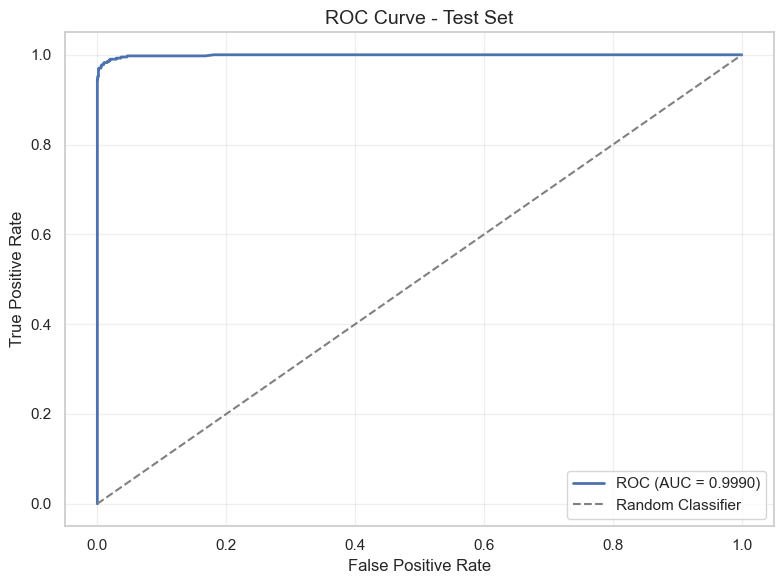

In [12]:
# Evaluate on test set
# CRITICAL: This is the FIRST time we use X_test - no data leakage!
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support

print('='*60)
print('FINAL EVALUATION ON TEST SET (unseen during training)')
print('='*60)

# Make predictions on test set
# The pipeline will apply SMOTE only if it was in the pipeline (but SMOTE only fits on training)
# For prediction, SMOTE is skipped automatically
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1] if hasattr(best_pipeline, 'predict_proba') else None

print('\nClassification report:')
print(classification_report(y_test, y_pred, digits=4, target_names=['Legitimate', 'Fraud']))

cm = confusion_matrix(y_test, y_pred)
print('\nConfusion matrix:')
print(cm)
print(f'True Negatives: {cm[0,0]}, False Positives: {cm[0,1]}')
print(f'False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}')

# ROC AUC (for binary labels)
if y_prob is not None:
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f'\nROC AUC Score: {roc_auc:.4f}')
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})', linewidth=2)
    plt.plot([0,1],[0,1],'--',color='gray', label='Random Classifier')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve - Test Set', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('\npredict_proba not available for this pipeline; skipping ROC plot')

,feature,importance
31,ERC20 min val rec,0.248675
24,ERC20 total ether sent,0.125329
37,ERC20 uniq sent token name,0.124323
22,Total ERC20 tnxs,0.124092
26,ERC20 uniq sent addr,0.115375
28,ERC20 uniq rec contract addr,0.036123
35,ERC20 max val sent,0.031883
38,ERC20 uniq rec token name,0.031079
27,ERC20 uniq rec addr,0.025089
23,ERC20 total Ether received,0.024202


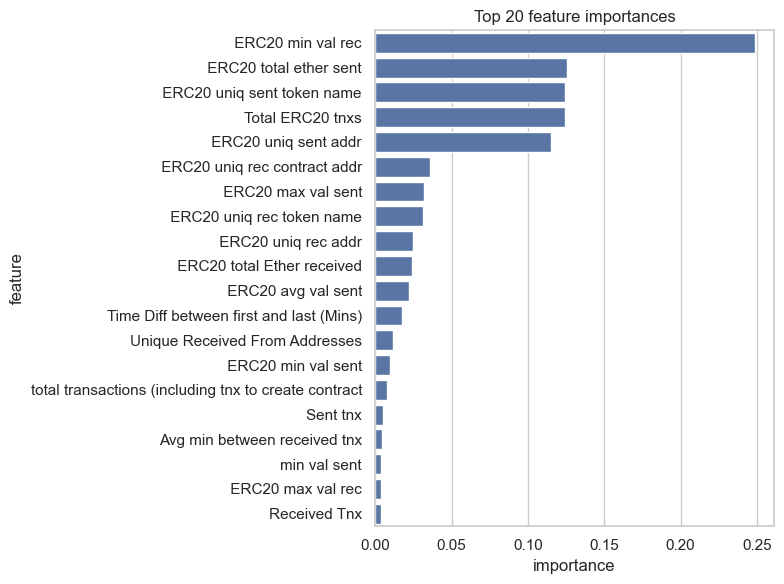

In [13]:
# Extract feature importances from the final RF inside pipeline
# Access rf step depending on pipeline type
try:
    rf_model = best_pipeline.named_steps['rf']
    importances = rf_model.feature_importances_
    feat_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances}).sort_values('importance', ascending=False)
    display(feat_df.head(20))
    plt.figure(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=feat_df.head(20))
    plt.title('Top 20 feature importances')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Could not extract feature importances:', e)

In [14]:
# Save the trained pipeline to disk
import joblib
model_path = 'rf_pipeline.joblib'
joblib.dump(best_pipeline, model_path)
print('Saved pipeline to', model_path)
# Example load: loaded = joblib.load(model_path)

Saved pipeline to rf_pipeline.joblib
